In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

# Stereo calibration

In [26]:
# Read checkerboard images

PATTERN_SIZE = (9, 6)
left_imgs = list(sorted(glob.glob('frames_pair/camera0_*.png')))
right_imgs = list(sorted(glob.glob('frames_pair/camera1_*.png')))
assert len(left_imgs) == len(right_imgs)

In [27]:
# Find checkerboard corners

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
left_pts, right_pts = [], []
img_size = None

for left_img_path, right_img_path in zip(left_imgs, right_imgs):
    left_img = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
    right_img = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)
    if img_size is None:
        img_size = (left_img.shape[1], left_img.shape[0])
    
    res_left, corners_left = cv2.findChessboardCorners(left_img, PATTERN_SIZE)
    res_right, corners_right = cv2.findChessboardCorners(right_img, PATTERN_SIZE)
    
    corners_left = cv2.cornerSubPix(left_img, corners_left, (10, 10), (-1,-1),
                                    criteria)
    corners_right = cv2.cornerSubPix(right_img, corners_right, (10, 10), (-1,-1), 
                                     criteria)
    
    left_pts.append(corners_left)
    right_pts.append(corners_right)

In [28]:
pattern_points = np.zeros((np.prod(PATTERN_SIZE), 3), np.float32)
pattern_points[:, :2] = np.indices(PATTERN_SIZE).T.reshape(-1, 2)
pattern_points = [pattern_points] * len(left_imgs)

In [29]:
err, Kl, Dl, Kr, Dr, R, T, E, F = cv2.stereoCalibrate(
    pattern_points, left_pts, right_pts, None, None, None, None, img_size, flags=0)

In [30]:
print('Left camera:')
print(Kl)
print('Left camera distortion:')
print(Dl)
print('Right camera:')
print(Kr)
print('Right camera distortion:')
print(Dr)
print('Rotation matrix:')
print(R)
print('Translation:')
print(T)

Left camera:
[[901.27394888   0.         654.59084986]
 [  0.         908.65140725 362.22003094]
 [  0.           0.           1.        ]]
Left camera distortion:
[[ 1.77441109e-01 -6.43534547e-01 -3.62084024e-03  4.14014261e-04
   1.21892060e+00]]
Right camera:
[[1.00722289e+03 0.00000000e+00 6.38980782e+02]
 [0.00000000e+00 1.01615771e+03 3.05959862e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Right camera distortion:
[[-0.26642581 -0.36254967  0.00381163  0.0036628   1.14300742]]
Rotation matrix:
[[ 0.99533206 -0.00409956  0.09642241]
 [ 0.00568827  0.99985247 -0.01620752]
 [-0.09634174  0.01668034  0.99520854]]
Translation:
[[-4.48274015]
 [-0.13167463]
 [ 0.658248  ]]


In [31]:
print('Reprojection error:', err)

Reprojection error: 1.4547918247229414


In [32]:
np.save('stereo.npy', {'Kl': Kl, 'Dl': Dl, 'Kr': Kr, 'Dr': Dr, 'R': R, 'T': T, 'E': E, 'F': F, 
                       'img_size': img_size, 'left_pts': left_pts, 'right_pts': right_pts})

# Aligning two images

In [9]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [54]:
left_img = cv2.imread(left_imgs[0], cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread(right_imgs[0], cv2.IMREAD_GRAYSCALE)

In [16]:
R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(Kl, Dl, Kr, Dr, img_size, R, T)

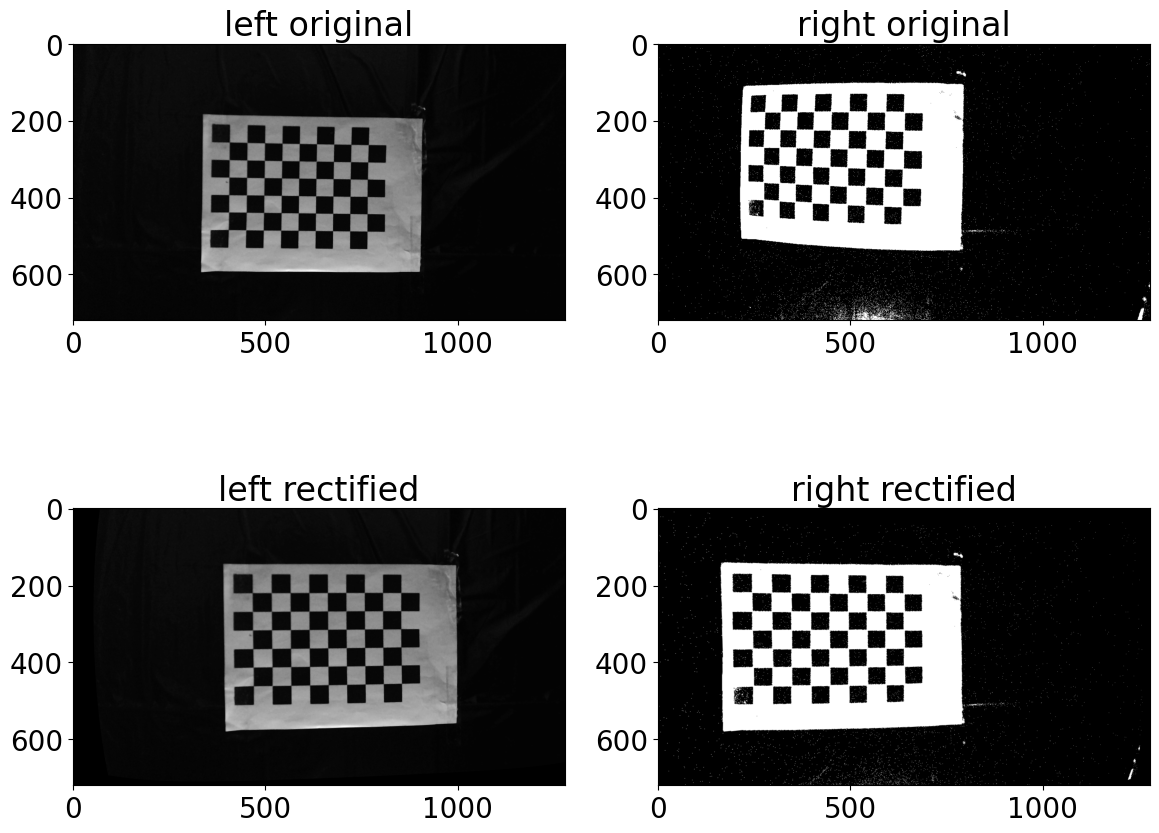

In [20]:
xmap1, ymap1 = cv2.initUndistortRectifyMap(Kl, Dl, R1, P1, img_size, cv2.CV_32FC1)
xmap2, ymap2 = cv2.initUndistortRectifyMap(Kr, Dr, R2, P2, img_size, cv2.CV_32FC1)
left_img_rectified = cv2.remap(left_img, xmap1, ymap1, cv2.INTER_LINEAR)
right_img_rectified = cv2.remap(right_img, xmap2, ymap2, cv2.INTER_LINEAR)
plt.figure(0, figsize=(12,10))
plt.subplot(221)
plt.title('left original')
plt.imshow(left_img, cmap='gray')
plt.subplot(222)
plt.title('right original')
plt.imshow(right_img, cmap='gray')
plt.subplot(223)
plt.title('left rectified')
plt.imshow(left_img_rectified, cmap='gray')
plt.subplot(224)
plt.title('right rectified')
plt.imshow(right_img_rectified, cmap='gray')
plt.tight_layout()
plt.show()

True


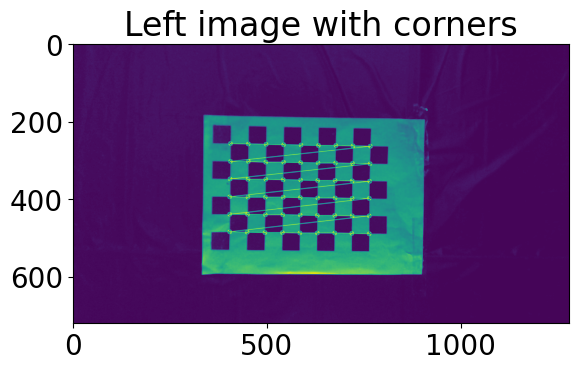

In [49]:
ret, corners = cv2.findChessboardCorners(left_img, PATTERN_SIZE, None)   # Find the chess board corners
print(ret)
# show

# copy image
left_copy = left_img.copy()

plt.imshow(cv2.drawChessboardCorners(left_copy, PATTERN_SIZE, corners, ret))
plt.title('Left image with corners')
plt.show()

[406.25958 258.12073]
[-1.15900822e-04  1.08461791e-02 -1.83473038e+00]


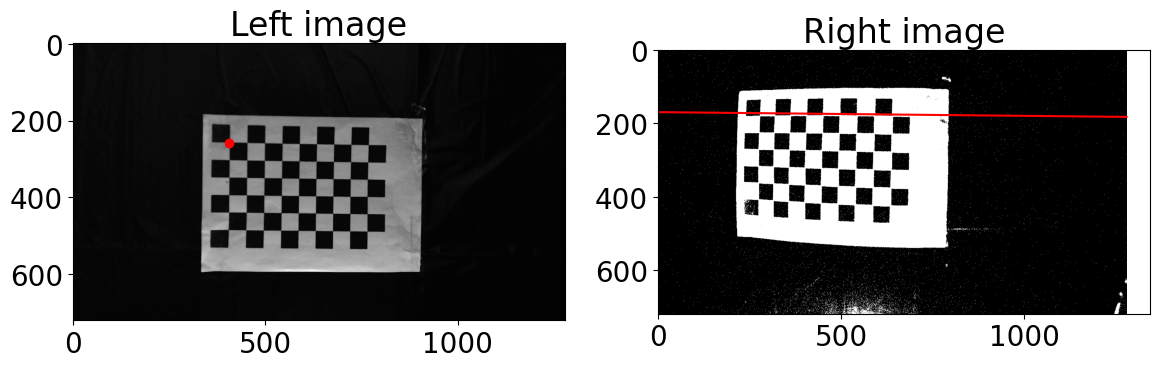

In [68]:
# draw image with point

point = corners[0,0]
print(point)    

# to homogeneous coordinates
point_h = np.array([point[0], point[1], 1])

# multiply with F
epipolar_line =  F@point_h 
print(epipolar_line)

#draw the epipolar line
x0 = 0
x1 = left_img.shape[1]
y0 = int(-epipolar_line[2] / epipolar_line[1])
y1 = int(-(epipolar_line[2] + epipolar_line[0] * x1) / epipolar_line[1])

# draw the epipolar line
plt.figure(1, figsize=(12,10))
plt.subplot(121)
plt.imshow(left_img, cmap='gray')
plt.plot(point[0], point[1], 'ro')
plt.title('Left image')
plt.subplot(122)
plt.imshow(right_img, cmap='gray')
plt.plot([x0, x1], [y0, y1], 'r')
plt.title('Right image')
plt.tight_layout()
plt.show()


In [17]:
corners[0,0]

array([465.3216 , 221.06512], dtype=float32)